<h1><center> Individual Data Noise Creation <br><br> 
<center> Scikit Mobility and DB Noise<br><br> 
Wendy Shi</center></center>

# TOC

- [County Level FIP](#County-Level-FIP-Code)
- [Individual Data](#Individual-Data)
- [Census Tract Shape File](#Census-Tract-Shape-File)
- [Grouping](#Groupping)
    - [DP Noise](#DP-Noise)
    - [Home Location](#Home-Location)
- [Computing Weight Matrix](#Computing-Weight-Matrix)

# Preparation

In [1]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

# County Level FIP Code

In [2]:
column_names = ['S', 'E', 'I', 'R']
Seeding = pd.read_csv("../../Data/seed_1503_seed_corrected_undereporting_CDC_corrected_v3.txt",
                     delimiter=' ',
                      names=column_names)
print(Seeding.shape)
Seeding.tail(3)

(2327, 4)


,S,E,I,R
2324,42158,0,0,0
2325,23347,0,0,0
2326,20441,0,0,0


In [3]:
node_dict = pd.read_csv("../../Data/nodes_considered.csv")
node_dict = node_dict.drop(columns = ['index'])
print(node_dict.shape)
node_dict.tail(3)

(2327, 1)


,GEO_ID
2324,56037
2325,56039
2326,56041


In [4]:
node_dict['Population'] = Seeding['S']
node_dict.tail(5)

,GEO_ID,Population
2322,56029,29656
2323,56033,30996
2324,56037,42158
2325,56039,23347
2326,56041,20441


In [5]:
#Check if node dictionary size equals to size of E, and see if they all have population larger than 11,000
desired = node_dict[node_dict['Population'] > 11000]
print(desired.shape)

node_dict["GEO_ID"] = node_dict["GEO_ID"].apply(lambda x: f"{int(x):05d}")

#rename column
rename = {'GEO_ID' : 'GEOID'}
node_dict = node_dict.rename(columns = rename)
node_dict.head(3)

(2327, 2)


,GEOID,Population
0,01001,58877
1,01003,233140
2,01005,25180


In [6]:
node_dict['state'] = node_dict['GEOID'].str[:2]
node_dict['index'] = range(len(node_dict))
node_dict.head(3)

,GEOID,Population,state,index
0,01001,58877,01,0
1,01003,233140,01,1
2,01005,25180,01,2


In [7]:
wisconsin = node_dict[node_dict['state'] == '55']

#Index list--------------This is the one that check if weight matrix is in the same order as SEIR initial condition
E_wi_index = wisconsin['GEOID'].to_list()

#Population list
pop_list = wisconsin['Population'].tolist()

#Print the dataset
print(wisconsin.shape)
wisconsin.head(3)

(67, 4)


,GEOID,Population,state,index
2245,55001,20673,55,2245
2246,55003,15977,55,2246
2247,55005,46643,55,2247


In [8]:
index = wisconsin['index'].tolist()
print(index)

[2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311]


# Original Matrix for reference

In [9]:
#Open the 12 weight matrix
column_names = ['origin', 'destination', 'count', 'weight']
for i in range(12):
    n = i +1
    
    df = pd.read_csv(f"../../Data/monthly_matrix_sd_county_month{n}_county.txt", 
                     delimiter=' ', names=column_names)
    
    #Making sure all origin and destination are states in New York
    df = df[(df['origin'].isin(index)) & (df['destination'].isin(index))]
    
    # Store the modified DataFrame
    globals()[f'wt_mt{n}'] = df

In [10]:
wt_mt12.head(3)

,origin,destination,count,weight
307170,2245,2255,12,0.034272
307171,2246,2255,12,0.001201
307172,2247,2255,12,0.000652


In [11]:
#Turn each data into a matrix
#Transform the dataframe to a matrix with pivot table
for i in range(12):
    n = i+1
    matrix = globals()[f'wt_mt{n}'].pivot_table(index='origin', 
                                                columns='destination', 
                                                values= 'weight', fill_value=0)
    matrix = matrix.reset_index()
    matrix = matrix.drop(columns = ["origin"]) #drop the origin column
    globals()[f'matrix{n}'] = matrix

In [12]:
for i in range(12):
    n = i +1
    count_df = globals()[f'matrix{n}'].multiply(pop_list, axis=0)
    globals()[f'count_df{n}'] = count_df

In [13]:
average_count_df = sum(globals()[f'count_df{i}'] for i in range(1, 13)) / 12
print(average_count_df.shape)
average_count_df.head(3)

(67, 67)


destination,2245,2246,2247,2248,2249,2250,2251,2252,2253,2254,...,2302,2303,2304,2305,2306,2307,2308,2309,2310,2311
0,9673.052937,8.162328,11.796554,7.871987,29.497926,9.365685,4.140227,20.037157,16.107175,13.515416,...,16.688009,18.905401,30.417285,8.967933,43.130300,97.217495,20.322076,303.240211,39.198856,998.110083
1,9.692306,8948.435975,50.944432,637.053110,39.071210,12.899256,16.518552,8.791647,21.782982,16.239812,...,11.174757,25.936058,21.006382,25.351507,16.347968,26.914088,15.072267,10.543590,22.697896,22.162232
2,14.266333,34.881470,31867.957956,44.420664,32.901986,25.263702,136.922895,10.649669,621.815089,34.045350,...,14.809613,15.404075,14.404283,796.772864,17.406194,28.563917,13.661593,12.295461,16.628103,29.817047


In [14]:
#Turn count to weight
divisor = [average_count_df.iloc[i].sum() for i in range(67)]
average_wt_mt = average_count_df.div(divisor, axis=0)
average_wt_mt.head(3)

destination,2245,2246,2247,2248,2249,2250,2251,2252,2253,2254,...,2302,2303,2304,2305,2306,2307,2308,2309,2310,2311
0,0.616262,0.000520,0.000752,0.000502,0.001879,0.000597,0.000264,0.001277,0.001026,0.000861,...,0.001063,0.001204,0.001938,0.000571,0.002748,0.006194,0.001295,0.019319,0.002497,0.063589
1,0.000855,0.789798,0.004496,0.056227,0.003448,0.001139,0.001458,0.000776,0.001923,0.001433,...,0.000986,0.002289,0.001854,0.002238,0.001443,0.002375,0.001330,0.000931,0.002003,0.001956
2,0.000376,0.000918,0.838874,0.001169,0.000866,0.000665,0.003604,0.000280,0.016368,0.000896,...,0.000390,0.000405,0.000379,0.020974,0.000458,0.000752,0.000360,0.000324,0.000438,0.000785


In [15]:
average_wt_mt_np = average_wt_mt.to_numpy()

In [16]:
average_wt_mt_np[0][0]

0.616262172884958

In [17]:
Pii_ori = [average_wt_mt_np[i][i] for i in range(67)]

In [18]:
data = Pii_ori 
mean_value = sum(data) / len(data)  # Mean
median_value = statistics.median(data)  # Median
min_value = min(data)  # Min
max_value = max(data)  # Max

# Output
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Length of the list: {len(Pii_ori)}")

Mean: 0.761600488841764
Median: 0.7635740517210533
Min: 0.6015341170934505
Max: 0.9200252642869884
Length of the list: 67


# Individual Data

## Different Layers of Census Data

- State (2 digit)
- County (5 digit)
- Census Tracts (4 digits)
- Census Block Groups
- Census tracts

In [19]:
data = pd.read_csv("WI_4Week_10000_realpop.csv")
data = data.drop(columns = 'Unnamed: 0')
print(data.shape)
data.head()

(4690626, 4)


,uid,datetime,lat,lng
0,1,2020-03-01 00:00:00.000000,44.249624,-88.409313
1,1,2020-03-01 00:28:14.055734,44.247095,-88.418595
2,1,2020-03-01 00:59:01.440932,44.249624,-88.409313
3,1,2020-03-01 01:23:36.368069,44.247095,-88.418595
4,1,2020-03-01 01:52:29.430108,44.249055,-88.427641


In [20]:
indi_visit_list = []
for i in range(10000):
    id_num = i+1
    #if i % 4000 == 0:
    #    print(i)
    indi_sub = data[data['uid'] == id_num]
    length = len(indi_sub)
    indi_visit_list.append(length)

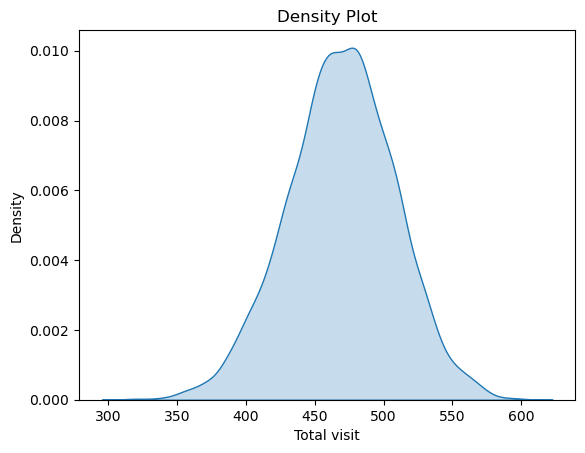

Min: 314
5%: 402.0
Median: 470.0
95%: 532.0
Max: 604


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(indi_visit_list, fill=True)
plt.xlabel('Total visit')
plt.ylabel('Density')
plt.title('Density Plot')
plt.show()

min_val = np.min(indi_visit_list)
P5 = np.percentile(indi_visit_list, 5)
median = np.median(indi_visit_list)
P95 = np.percentile(indi_visit_list, 95)
max_val = np.max(indi_visit_list)

print(f"Min: {min_val}")
print(f"5%: {P5}")
print(f"Median: {median}")
print(f"95%: {P95}")
print(f"Max: {max_val}")

# Census Tract Shape File

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
- Go to Data
- Mapping file
- TIGER/Line Geodatabases (GIS)


Here's the county level shape file:
https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [23]:
#Note that geopandas only works in ipykernel environment
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads

## trying census block group this time!

In [24]:
#url = "https://www2.census.gov/geo/tiger/TIGER2020/BG/tl_2020_53_bg.zip"
#tracts = gpd.read_file(url)[["GEOID", "geometry"]]
tracts = gpd.read_file("tl_2020_55_bg/tl_2020_55_bg.shp")[["GEOID", "geometry"]]
print(tracts.columns)
print(tracts.shape)
tracts.head(1) 

Index(['GEOID', 'geometry'], dtype='object')
(4692, 2)


,GEOID,geometry
0,551332016003,"POLYGON ((-88.19888 42.93020, -88.19884 42.930..."


In [26]:
#Maing sure the shape file that we use to perform Geospacial join are all in countis of interest
tracts['County'] = tracts['GEOID'].str[:5].copy()
tracts = tracts[tracts['County'].isin(E_wi_index)]
print(tracts.shape)
tracts.head(3)

(4655, 3)


,GEOID,geometry,County
0,551332016003,"POLYGON ((-88.19888 42.93020, -88.19884 42.930...",55133
1,551332015043,"POLYGON ((-88.08879 42.92421, -88.08866 42.924...",55133
2,551332025004,"POLYGON ((-88.22182 43.00307, -88.22180 43.003...",55133


In [27]:
len(tracts['County'].unique().tolist())

67

In [28]:
#To test if they are all New York Data
test = tracts.copy()
test['state'] = test['GEOID'].str[:2]
unique_state = test['state'].unique().tolist()
unique_state

['55']

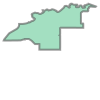

In [29]:
tracts.iloc[11,1]

## Individual trajectory data

In [30]:
print(data.shape)
data.head()

(4690626, 4)


,uid,datetime,lat,lng
0,1,2020-03-01 00:00:00.000000,44.249624,-88.409313
1,1,2020-03-01 00:28:14.055734,44.247095,-88.418595
2,1,2020-03-01 00:59:01.440932,44.249624,-88.409313
3,1,2020-03-01 01:23:36.368069,44.247095,-88.418595
4,1,2020-03-01 01:52:29.430108,44.249055,-88.427641


### This takes 5-8 seconds

In [31]:
# Convert latitude/longitude into Point geometry
geometry = [Point(xy) for xy in zip(data["lng"], data["lat"])] #Convert coordinate to points

# Create a GeoDataFrame with the same CRS as the Census Tract shapefile
points_gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

points_gdf.head() # Check that geometry was created correctly

,uid,datetime,lat,lng,geometry
0,1,2020-03-01 00:00:00.000000,44.249624,-88.409313,POINT (-88.40931 44.24962)
1,1,2020-03-01 00:28:14.055734,44.247095,-88.418595,POINT (-88.41859 44.24710)
2,1,2020-03-01 00:59:01.440932,44.249624,-88.409313,POINT (-88.40931 44.24962)
3,1,2020-03-01 01:23:36.368069,44.247095,-88.418595,POINT (-88.41859 44.24710)
4,1,2020-03-01 01:52:29.430108,44.249055,-88.427641,POINT (-88.42764 44.24906)


In [32]:
# Convert Census Tract shapefile to the same CRS as the points
# This is to make sure both data use EPSG:4326
tracts = tracts.to_crs(points_gdf.crs)
tracts.head()

,GEOID,geometry,County
0,551332016003,"POLYGON ((-88.19888 42.93020, -88.19884 42.930...",55133
1,551332015043,"POLYGON ((-88.08879 42.92421, -88.08866 42.924...",55133
2,551332025004,"POLYGON ((-88.22182 43.00307, -88.22180 43.003...",55133
3,551332014022,"POLYGON ((-88.08815 42.99696, -88.08813 42.997...",55133
4,550339703001,"POLYGON ((-91.89454 45.00255, -91.89449 45.003...",55033


In [33]:
#Proceed when we see the same CRS value
print("Tracts CRS:", tracts.crs)
print("Points CRS:", points_gdf.crs)

Tracts CRS: EPSG:4326
Points CRS: EPSG:4326


## This takes three seconds

In [34]:
print(len(tracts['County'].unique().tolist()))
tracts.head(1)

67


,GEOID,geometry,County
0,551332016003,"POLYGON ((-88.19888 42.93020, -88.19884 42.930...",55133


In [35]:
#Perform spacial join
joined_gdf = gpd.sjoin(points_gdf, tracts, how="left", predicate="within")
print(joined_gdf.shape)
joined_gdf.head(3)

(4690626, 8)


,uid,datetime,lat,lng,geometry,index_right,GEOID,County
0,1,2020-03-01 00:00:00.000000,44.249624,-88.409313,POINT (-88.40931 44.24962),4080,550870108002,55087
1,1,2020-03-01 00:28:14.055734,44.247095,-88.418595,POINT (-88.41859 44.24710),4062,550870108001,55087
2,1,2020-03-01 00:59:01.440932,44.249624,-88.409313,POINT (-88.40931 44.24962),4080,550870108002,55087


In [36]:
joined_gdf['datetime'] = pd.to_datetime(joined_gdf['datetime'])
joined_gdf['day'] = joined_gdf['datetime'].dt.day
joined_gdf.tail(3)

,uid,datetime,lat,lng,geometry,index_right,GEOID,County,day
4690623,10000,2020-03-30 19:20:14.690926,43.894577,-91.231324,POINT (-91.23132 43.89458),2140,550630104032,55063,30
4690624,10000,2020-03-30 23:30:48.981380,43.555867,-89.801037,POINT (-89.80104 43.55587),3864,551110001031,55111,30
4690625,10000,2020-03-30 23:57:54.460018,44.931692,-91.417906,POINT (-91.41791 44.93169),1353,550170103005,55017,30


In [37]:
joined_gdf = joined_gdf[~(joined_gdf['County'].isna())].copy()
print(len(joined_gdf['County'].unique().tolist()))

67


# Groupping

## Here's Where to add noise

In [38]:
#Grouped
grouped_counts = joined_gdf.groupby(['uid', 'day','GEOID']).size().reset_index()
rename = {0 : 'Count'}
grouped_counts = grouped_counts.rename(columns = rename)
grouped_counts.head(10)

,uid,day,GEOID,Count
0,1,1,550870103001,1
1,1,1,550870106021,1
2,1,1,550870107001,1
3,1,1,550870107003,1
4,1,1,550870107004,1
5,1,1,550870108001,4
6,1,1,550870108002,5
7,1,1,550870109002,1
8,1,1,550870110022,1
9,1,1,550870125031,5


In [39]:
grouped_counts.insert(3, "County", grouped_counts['GEOID'].str[:5]) #State + county is a five digit code

#One individual has about 30 unique locations
print(grouped_counts.shape)
grouped_counts.head(5)

(3526025, 5)


,uid,day,GEOID,County,Count
0,1,1,550870103001,55087,1
1,1,1,550870106021,55087,1
2,1,1,550870107001,55087,1
3,1,1,550870107003,55087,1
4,1,1,550870107004,55087,1


In [40]:
unique_id = grouped_counts['uid'].unique().tolist()
print(len(unique_id))

10000


# DP Noise

In [41]:
import opendp.prelude as dp
dp.enable_features("contrib")

#The Loop
privacy_budget = [0.8, 0.5, 0.3, 0.1, 0.05, 0.01, 0.005]
name = ['P8','P5','P3','P1','P05','P01','P005']

# Ensure the 'Count' column is float before applying DP noise
grouped_counts['Count'] = grouped_counts['Count'].astype(int).copy()

for i in range(len(privacy_budget)):
    print(i)
    epsilon = privacy_budget[i] #Privacy budget
    sensitivity = 1
    scale = sensitivity / epsilon
    
    # Create the Laplace mechanism
    laplace_mechanism = dp.m.make_laplace(
        dp.atom_domain(T=int), dp.absolute_distance(T=int), scale)
    
    #Define the Laplace function
    def apply_dp_noise(count):
        return laplace_mechanism(count)
    
    #Name for the new column
    text = name[i]
    
    grouped_counts[f'Count_{text}'] = grouped_counts['Count'].apply(lambda x: max(laplace_mechanism(x), 0))
    

0
1
2
3
4
5
6


In [42]:
grouped_counts.head(10)

,uid,day,GEOID,County,Count,Count_P8,Count_P5,Count_P3,Count_P1,Count_P05,Count_P01,Count_P005
0,1,1,550870103001,55087,1,1,4,1,1,0,0,0
1,1,1,550870106021,55087,1,2,0,12,0,41,2,0
2,1,1,550870107001,55087,1,5,0,0,11,8,0,0
3,1,1,550870107003,55087,1,3,4,0,2,48,45,375
4,1,1,550870107004,55087,1,2,4,2,10,0,0,0
5,1,1,550870108001,55087,4,4,2,8,0,0,0,28
6,1,1,550870108002,55087,5,6,8,16,6,61,0,75
7,1,1,550870109002,55087,1,0,2,2,10,70,40,159
8,1,1,550870110022,55087,1,1,2,8,0,0,0,0
9,1,1,550870125031,55087,5,5,4,3,4,0,116,0


#

# Home Location

In [44]:
home = pd.read_csv("Home_location_4Week_10000_WI_realpop.csv")
home = home.drop(columns = 'Unnamed: 0')
print(home.shape)
home.head()

(10000, 3)


,uid,lat,lng
0,1,44.249624,-88.409313
1,2,44.265812,-88.481455
2,3,45.304181,-89.677755
3,4,44.289490,-88.547518
4,5,42.737984,-87.795110


In [45]:
# Convert latitude/longitude into Point geometry
geometry = [Point(xy) for xy in zip(home["lng"], home["lat"])] #Convert coordinate to points

# Create a GeoDataFrame with the same CRS as the Census Tract shapefile
home_points_gdf = gpd.GeoDataFrame(home, geometry=geometry, crs="EPSG:4326")

home_points_gdf.head()  # Check that geometry was created correctly

,uid,lat,lng,geometry
0,1,44.249624,-88.409313,POINT (-88.40931 44.24962)
1,2,44.265812,-88.481455,POINT (-88.48146 44.26581)
2,3,45.304181,-89.677755,POINT (-89.67775 45.30418)
3,4,44.289490,-88.547518,POINT (-88.54752 44.28949)
4,5,42.737984,-87.795110,POINT (-87.79511 42.73798)


In [46]:
print("Tracts CRS:", tracts.crs)
print("Points CRS:", home_points_gdf.crs)

Tracts CRS: EPSG:4326
Points CRS: EPSG:4326


In [47]:
print(len(tracts['County'].unique().tolist()))
tracts.head(3)

67


,GEOID,geometry,County
0,551332016003,"POLYGON ((-88.19888 42.93020, -88.19884 42.930...",55133
1,551332015043,"POLYGON ((-88.08879 42.92421, -88.08866 42.924...",55133
2,551332025004,"POLYGON ((-88.22182 43.00307, -88.22180 43.003...",55133


In [48]:
home_joined_gdf = gpd.sjoin(home_points_gdf, tracts, how="left", predicate="within")
print(home_joined_gdf.shape)
home_joined_gdf.head(3)

(10000, 7)


,uid,lat,lng,geometry,index_right,GEOID,County
0,1,44.249624,-88.409313,POINT (-88.40931 44.24962),4080,550870108002,55087
1,2,44.265812,-88.481455,POINT (-88.48146 44.26581),3980,550870125062,55087
2,3,45.304181,-89.677755,POINT (-89.67775 45.30418),1020,550699607001,55069


In [49]:
#home geoid at the county level
home_joined_gdf['home_geoid'] = home_joined_gdf['GEOID'].str[:5] 
home_joined_gdf.head(3)

,uid,lat,lng,geometry,index_right,GEOID,County,home_geoid
0,1,44.249624,-88.409313,POINT (-88.40931 44.24962),4080,550870108002,55087,55087
1,2,44.265812,-88.481455,POINT (-88.48146 44.26581),3980,550870125062,55087,55087
2,3,45.304181,-89.677755,POINT (-89.67775 45.30418),1020,550699607001,55069,55069


In [50]:
print(len(home_joined_gdf['home_geoid'].unique().tolist()))

67


### This is where home list is computed!!! Important!!!

In [51]:
#Home list------------------------------------------------!!------------!!-----------
home_list = home_joined_gdf['home_geoid'].tolist()
len(home_list)

10000

In [52]:
home = home_joined_gdf[home_joined_gdf['uid'] == 1]['GEOID'][0]
home

'550870108002'

In [53]:
us_shape_file = pd.read_csv("../../Data/us_shapefile_county.csv")

#rename column
rename = {"FIPS code" : "GEOID"}
us_shape_file = us_shape_file.rename(columns = rename)
us_shape_file["GEOID"] = us_shape_file["GEOID"].apply(lambda x: f"{int(x):05d}")
us_shape_file = us_shape_file[['GEOID','pop2020']].copy()
us_shape_file.tail(3)

,GEOID,pop2020
3106,06037,9989165.0
3107,46113,14309.0
3108,51515,6599.0


In [54]:
home_groped= home_joined_gdf.groupby('home_geoid').size().reset_index(name='Count')
rename = {'home_geoid' :'GEOID'}
home_groped = home_groped.rename(columns = rename)
home_groped.head(3)

,GEOID,Count
0,55001,24
1,55003,31
2,55005,93


In [55]:
home_merged = pd.merge(us_shape_file, home_groped, on = 'GEOID', how = 'inner')
home_merged.head(3)

,GEOID,pop2020,Count
0,55011,13320.0,17
1,55099,14015.0,22
2,55107,14168.0,20


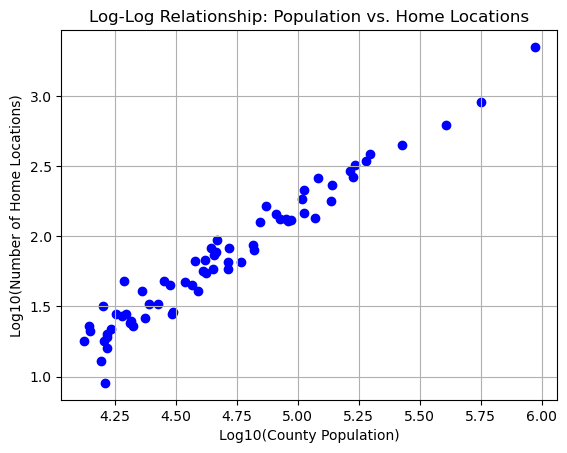

In [56]:
home_merged['log_pop2021'] = np.log10(home_merged['pop2020'] + 1)
home_merged['log_Count'] = np.log10(home_merged['Count'] + 1)

import matplotlib.pyplot as plt

plt.scatter(home_merged['log_pop2021'], home_merged['log_Count'], color='blue')
#plt.scatter(home_merged['pop2021'], home_merged['Count'], color='blue')
plt.xlabel('Log10(County Population)')
plt.ylabel('Log10(Number of Home Locations)')
plt.title('Log-Log Relationship: Population vs. Home Locations')
plt.grid(True)
plt.show()

### Test if it is a linear relationship

In [57]:
from sklearn.linear_model import LinearRegression

# Reshape X to 2D
X = home_merged[['pop2020']]  # double brackets = 2D DataFrame
y = home_merged['Count']

model = LinearRegression()
model.fit(X, y)

r_squared = model.score(X, y)
print("R² score:", r_squared)

slope = model.coef_[0]
intercept = model.intercept_

print(f"Estimated slope (β₁): {slope}")
print(f"Estimated intercept (β₀): {intercept}")

R² score: 0.9602762930201532
Estimated slope (β₁): 0.0021224375763957866
Estimated intercept (β₀): -36.40852305499587


#

# The Loop

In [58]:
print(grouped_counts.shape)
grouped_counts.head(5)

(3526025, 12)


,uid,day,GEOID,County,Count,Count_P8,Count_P5,Count_P3,Count_P1,Count_P05,Count_P01,Count_P005
0,1,1,550870103001,55087,1,1,4,1,1,0,0,0
1,1,1,550870106021,55087,1,2,0,12,0,41,2,0
2,1,1,550870107001,55087,1,5,0,0,11,8,0,0
3,1,1,550870107003,55087,1,3,4,0,2,48,45,375
4,1,1,550870107004,55087,1,2,4,2,10,0,0,0


### Assign home locaton to each individual

In [59]:
# Enpty Data Frame
ori_des_df = pd.DataFrame()
person_id = grouped_counts["uid"].unique().tolist()

#The Loop
for i in range(len(person_id)):
    
    if i % 4000 == 0:
        print(i)
    
    #Reset_index: This makes sure that everytime we do the subset, index start with 1
    person = grouped_counts[grouped_counts['uid'] == person_id[i]].reset_index().copy()
    person = person.drop(columns = ['index']) #since it create a separate column of index, we drop it!
    
    #Use existing data to find home location
    Origin = home_list[i]
    
    #Insert Origin, shift county to the right as 'Destination'
    person.insert(3, "Origin", Origin)
    
    #rename column
    rename = {'County': 'Destination'}
    person = person.rename(columns = rename)
    
    #Concat the result
    #Note that each row are count for one census block, convert them into origin and destinaion
    ori_des_df = pd.concat([ori_des_df, person], axis = 0)

0
4000
8000


In [60]:
print(ori_des_df.shape)
ori_des_df.head(3)
#ori_des_df.to_excel("ori_des_df.xlsx")

(3526025, 13)


,uid,day,GEOID,Origin,Destination,Count,Count_P8,Count_P5,Count_P3,Count_P1,Count_P05,Count_P01,Count_P005
0,1,1,550870103001,55087,55087,1,1,4,1,1,0,0,0
1,1,1,550870106021,55087,55087,1,2,0,12,0,41,2,0
2,1,1,550870107001,55087,55087,1,5,0,0,11,8,0,0


In [62]:
ori_des_df = ori_des_df[ori_des_df['Origin'].isin(E_wi_index)]
ori_des_df = ori_des_df[ori_des_df['Destination'].isin(E_wi_index)]

In [63]:
ori_des_df.shape

(3526025, 13)

# Computing-Weight-Matrix

### Average Matrix Epsilon

In [67]:
def avg_mt_epsilon(Count):
    
    '''
    Calculating average mobility matrix for each day (1–30).
    This returns a dictionay of Daily Matrix
    '''
    
    Matrix_dict = {}

    for i in range(30):
        n = i + 1
        df = ori_des_df[ori_des_df['day'] == n]
        
        county_group = df.groupby(['Origin', 'Destination'])[Count].sum().reset_index()

        count_Matrix = county_group.pivot_table(index='Origin', 
                                                columns='Destination', 
                                                values= Count, 
                                                fill_value=0)
        
        #This is a new line of code added by ChatGTP: sort index in accending order
        count_Matrix = count_Matrix.sort_index().sort_index(axis=1)

        origin_list = count_Matrix.index.tolist()
        destination_list = count_Matrix.columns.tolist()
        #This is just to ensure if the row index and column index are in the same orde
        #As well as to ensure they also equals to the initial SEIR condition county order
        #If nothing goes wrong the loop will not print anything

        if origin_list != destination_list:
            print(f'Day {n}: origin list ≠ destination list')

        if origin_list != E_wi_index:
            print(f'Day {n}: origin list ≠ SEIR initial condition list')

        Matrix = count_Matrix.reset_index(drop=True)
        Matrix_dict[n] = Matrix

    return Matrix_dict

### Daily Average Matrix

In [68]:
def daily_avg_wtmt(Matrix_dict):
    
    '''
    This function compute the daily average mobility matrix
    '''
    total_visit = Matrix_dict[1].copy()
    mt_length = len(total_visit.columns)
    
    for i in range(1, 30):
        n = i + 1 #n therefore starts from 2
        #print(n)
        
        if n % 10 == 0:
            print(n)
            
        total_visit += Matrix_dict[n]
        
    daily_avg_visit = total_visit/30
    
    divisor = [daily_avg_visit.iloc[i].sum() for i in range(mt_length)]
    average_wt_mt = daily_avg_visit.div(divisor, axis=0)
    
    return average_wt_mt

# Saving the Weight Matrix

In [101]:
Matrix_dict = avg_mt_epsilon('Count')
Matrix_dict[1].head(3)

Destination,55001,55003,55005,55007,55009,55011,55013,55015,55017,55019,...,55123,55125,55127,55129,55131,55133,55135,55137,55139,55141
0,155,0,0,0,21,0,0,0,0,3,...,7,2,1,0,0,7,13,3,6,26
1,0,260,0,38,7,0,0,0,2,1,...,1,2,0,0,0,17,3,0,1,2
2,1,1,1037,7,5,6,20,8,36,5,...,7,5,0,57,0,6,9,0,7,4


In [102]:
daily_avg = daily_avg_wtmt(Matrix_dict)
daily_avg.head(3)

10
20
30


Destination,55001,55003,55005,55007,55009,55011,55013,55015,55017,55019,...,55123,55125,55127,55129,55131,55133,55135,55137,55139,55141
0,0.176975,0.000000,0.001174,0.000000,0.064289,0.000090,0.000181,0.007946,0.001354,0.001986,...,0.012009,0.001354,0.003521,0.000361,0.002980,0.027178,0.020587,0.006230,0.023476,0.061400
1,0.001713,0.473764,0.018222,0.034731,0.021578,0.000343,0.003151,0.001918,0.008015,0.002398,...,0.001028,0.003357,0.002192,0.001713,0.002535,0.029251,0.005480,0.001165,0.008974,0.006371
2,0.001426,0.002897,0.473799,0.002529,0.006507,0.002989,0.008393,0.004461,0.038767,0.003012,...,0.004162,0.000943,0.004047,0.027316,0.001633,0.009703,0.004231,0.001081,0.007864,0.005679


In [103]:
# Calculations
import statistics

average_wt_mt_np = daily_avg.to_numpy()
Pii_skmob = [average_wt_mt_np[i][i] for i in range(67)]


data = Pii_skmob 
mean_value = sum(data) / len(data)  # Mean
median_value = statistics.median(data)  # Median
min_value = min(data)  # Min
max_value = max(data)  # Max

# Output
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")

Mean: 0.42448859472037204
Median: 0.36489652961053703
Min: 0.14626945786366077
Max: 0.867181631351428


In [100]:
#daily_avg.to_csv("WI_ori_indi.csv")

# Compares it to the Original

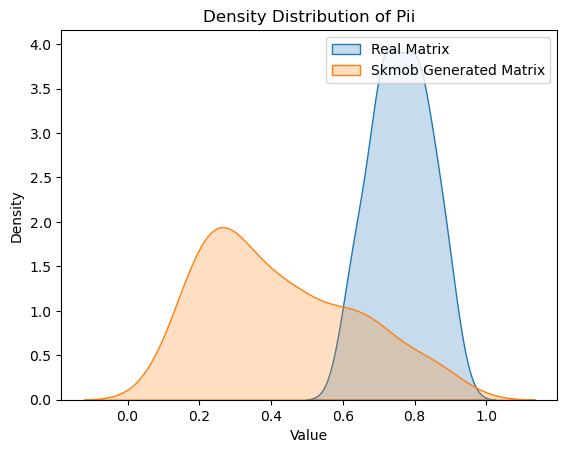

In [104]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create KDE plot
sns.kdeplot(Pii_ori, label="Real Matrix", fill=True)
sns.kdeplot(Pii_skmob, label="Skmob Generated Matrix", fill=True)

# Labels and legend
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Density Distribution of Pii")
plt.legend()

#Lables and legend
#plt.savefig("Pii_Comparison.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()
